# Introduction

Web scrapping extracts web content, usually in the form of texture characters through looking at HTML. It is a skill ought to be possessed by one working on data-related projects. [Jesses Steinweg-Woods](https://jessesw.com/Data-Science-Skills/) wrote a post about extracting skills required by data scientist job advertisements on Indeed in 2015. Since then, Indeed has changed the layout of their website, it's no longer plain HTML, but requires some "interactions" with the javascript. Based on his idea, I wrote a code to enable the "interactions" and extract the job skills using just Selenium.

Basically, each job advertisement on Indeed has a base address plus a unique job ID. For example, https://www.indeed.com/jobs?q=%22data+scientist%22&l=Houston,+TX&vjk=9b6647ed6c731326, where the letters-numbers after vjk is the job ID. The code first get the job IDs, "visits" each "job page" and extracts the content, followed by post-processing.

<img src="screenshot.png">

Load libraries.

In [1]:
from nltk.corpus import stopwords
from collections import Counter
import numpy as np
import re
import pandas as pd
from matplotlib import pyplot as plt

Load Selenium Libraries. Install geckodriver at https://github.com/mozilla/geckodriver/releases

In [2]:
from selenium.webdriver import Firefox
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.support import expected_conditions as expected
from selenium.webdriver.support.wait import WebDriverWait
from selenium.common.exceptions import TimeoutException
geckodriver_path = '/home/wfgoh/geckodriver' # location of geckodriver

Each job advertisement has a base address followed by a unique ID. Use Selenium to go to each page (each page has roughly 10 jobs) to get their unique IDs. Note that some jobs might appear on more than one page.

In [3]:
def get_jobid(what,city,state):
    total_job = 500 # job limit
    jobid = []
    seen = set(jobid)
    prev_job_num = 0
    for i in range(0,total_job,10):
        web = 'https://www.indeed.com/jobs?q="'+str(what)+'"&l='+str(city)+',+'+str(state)+'&start='+str(i)
        web_base = 'https://www.indeed.com/jobs?q="'+str(what)+'"&l='+str(city)+',+'+str(state)
        options = Options()
        options.add_argument('-headless')
        driver = Firefox(executable_path=geckodriver_path, firefox_options=options)
        wait = WebDriverWait(driver, timeout=10)
        driver.get(web)
        src = driver.page_source
        driver.quit()

        if i == 0:
            #print(web)
            for line in src.splitlines():
                if 'name=\"description\"' in line:
                    line = re.sub("[^a-zA-Z0-9]","", line)
                    num_job = re.findall('\d+',line)[0]
            print(num_job, ' Data Scientist jobs available in ', city, state,' on Indeed.com.' )

        for line in src.splitlines():
            if 'jobKeysWithInfo[\'' in line:
                jid = line.split('\'')[1]
                if jid not in seen:
                    seen.add(jid)
                    jobid.append(jid)
                    
        if len(jobid) == num_job or len(jobid) == prev_job_num:
            print('Number of (non-repeated) job found = ',len(jobid))
            break
        prev_job_num = len(jobid)

    return jobid, web_base

This get_text function "interacts" with the javascript using Selenium and displays the web content. The content is then processed by removing non-alphabets and stop words, such as "a", "an", "the", etc.

In [4]:
def get_text(website):
    
    options = Options()
    options.add_argument('-headless')
    driver = Firefox(executable_path=geckodriver_path, firefox_options=options)
    #wait = WebDriverWait(driver, timeout=10)
    driver.get(website)
    try:
        wait = WebDriverWait(driver, 15)
        condition = expected.element_to_be_clickable((By.ID, 'vjs-container'))
        element = wait.until(condition)
        vjs = driver.find_element_by_id('vjs-container')
        content = vjs.text
    except TimeoutException as e:
        print(e)
    #vjs = driver.find_element_by_id('vjs-container')
    #content = vjs.text
    driver.quit()
    
    text = re.sub("[^a-zA-Z]"," ", content).lower().split()
    stop_words = set(stopwords.words("english"))
    text = sorted(list(set([w for w in text if not w in stop_words])))
    
    return text

Extract the job description for each job using get_text function (see above). Each job has an address of base + vjk=ID.

In [5]:
def get_job_desc(jobid,web_base):
    urls = []
    for i in range(len(jobid)):
        urls.append(web_base+'&vjk='+str(jobid[i]))
    job_desc = []
    for website in urls:
        #print(website)
        desc = get_text(website)
        if desc:
            job_desc.append(desc)
    print('Number of (non-repeated) jobs found = ', len(job_desc))
    return job_desc

Last step, count the number of occurences with Counter.

In [6]:
def count_tools(job_desc):
    freq = Counter()
    [freq.update(item) for item in job_desc]
    dict_prog = Counter({'Python':freq['python'], 'R':freq['r'], 'Fortran':freq['fortran'],
                        'Java':freq['java'], 'C++':freq['c++'], 'Ruby':freq['ruby'],
                        'Mathematica':freq['mathematica'], 'Matlab':freq['matlab'], 'Perl':freq['perl'], 
                        'JavaScript':freq['javascript'], 'Scala': freq['scala']})

    dict_analy = Counter({'Excel':freq['excel'],  'Tableau':freq['tableau'], 'D3.js':freq['d3.js'], 
                        'SAS':freq['sas'], 'SPSS':freq['spss'], 'D3':freq['d3']})  

    dict_hadoop = Counter({'Hadoop':freq['hadoop'], 'MapReduce':freq['mapreduce'], 'Spark':freq['spark'],
                    'Pig':freq['pig'], 'Hive':freq['hive'], 'Shark':freq['shark'],
                    'Oozie':freq['oozie'], 'ZooKeeper':freq['zookeeper'], 'Flume':freq['flume'],
                    'Mahout':freq['mahout']})

    dict_datab = Counter({'SQL':freq['sql'], 'NoSQL':freq['nosql'], 'HBase':freq['hbase'],
                        'Cassandra':freq['cassandra'], 'MongoDB':freq['mongodb']})

    dict_total = dict_prog + dict_analy + dict_hadoop + dict_datab
    
    return dict_total.most_common()

Let's look for Data Scientist jobs within Houston, TX!

In [69]:
jobid, web_base = get_jobid('data+scientist','Houston','TX')
job_desc = get_job_desc(jobid,web_base)
data = count_tools(job_desc)

35  Data Scientist jobs available in  Houston TX  on Indeed.com.
Number of (non-repeated) job found =  32
https://www.indeed.com/jobs?q="data+scientist"&l=Houston,+TX&vjk=9b6647ed6c731326
https://www.indeed.com/jobs?q="data+scientist"&l=Houston,+TX&vjk=2d968e6ab489a5c5
https://www.indeed.com/jobs?q="data+scientist"&l=Houston,+TX&vjk=d66abdca626064cd
https://www.indeed.com/jobs?q="data+scientist"&l=Houston,+TX&vjk=a6e22bcf691b7dbe
https://www.indeed.com/jobs?q="data+scientist"&l=Houston,+TX&vjk=c31bb8e1dd53e576
https://www.indeed.com/jobs?q="data+scientist"&l=Houston,+TX&vjk=f3ffa6c9503838c1
https://www.indeed.com/jobs?q="data+scientist"&l=Houston,+TX&vjk=8c00d8e1e48fee9c
https://www.indeed.com/jobs?q="data+scientist"&l=Houston,+TX&vjk=30f92fc8a5035c91
https://www.indeed.com/jobs?q="data+scientist"&l=Houston,+TX&vjk=3e775b4e96b68910
https://www.indeed.com/jobs?q="data+scientist"&l=Houston,+TX&vjk=361412f227add1f3
https://www.indeed.com/jobs?q="data+scientist"&l=Houston,+TX&vjk=80b91998b

Plot the results.

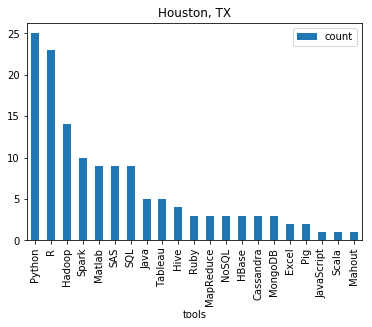

In [70]:
pd.DataFrame(data, columns = ['tools','count']).plot.bar('tools','count')
plt.title('Houston, TX')
plt.show()